In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import PIL
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.applications import ResNet50


In [2]:
df = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
df['Dataset_type'].value_counts()

In [ ]:
# imbalanced dataset, might need to downsample
df['Label'].value_counts()

## Get training imgs and split into normal and pnemonia

In [3]:
df.loc[df['Dataset_type']=='TRAIN']['Label'].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

In [4]:
Normal_Img = list(df.loc[(df['Dataset_type']=='TRAIN') & (df['Label']=='Normal')]['X_ray_image_name'])
Pnemonia_Img = list(df.loc[(df['Dataset_type']=='TRAIN') & (df['Label']=='Pnemonia')]['X_ray_image_name'])
print(Pnemonia_Img[:8])

['person101_virus_188.jpeg', 'person101_virus_187.jpeg', 'person1019_virus_1708.jpeg', 'person1019_virus_1707.jpeg', 'person1019_bacteria_2950.jpeg', 'person1018_virus_1706.jpeg', 'person1018_bacteria_2949.jpeg', 'person1017_bacteria_2948.jpeg']


In [5]:
# Downsample to 1000 from each type
train_img_dir = '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
Normal_train_images = list(map(lambda x: os.path.join(train_img_dir, x), Normal_Img))[:1000]
Pnemonia_train_images = list(map(lambda x: os.path.join(train_img_dir, x), Pnemonia_Img))[:1000]
print(len(Normal_train_images))
print(len(Pnemonia_train_images))


1000
1000


In [6]:
chest_images_dict = {
    'Normal': Normal_train_images,
    'Pnemonia': Pnemonia_train_images,
}
chest_labels_dict = {
    'Normal': 0,
    'Pnemonia': 1,
}

In [7]:
img = cv2.imread(str(chest_images_dict['Normal'][55]))
img.shape

(1480, 1804, 3)

## Prepare X and y

In [8]:
X, y = [], []

for label, images in chest_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(chest_labels_dict[label])

In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(1600, 224, 224, 3)


In [11]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## Build a CNN

In [25]:
model = keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=5)  

Epoch 1/5
50/50 [==============================] - 5s 24ms/step - loss: 0.5320 - accuracy: 0.7925
Epoch 2/5
50/50 [==============================] - 1s 24ms/step - loss: 0.1293 - accuracy: 0.9588
Epoch 3/5
50/50 [==============================] - 1s 22ms/step - loss: 0.0852 - accuracy: 0.9737
Epoch 4/5
50/50 [==============================] - 1s 24ms/step - loss: 0.0629 - accuracy: 0.9775
Epoch 5/5
50/50 [==============================] - 1s 22ms/step - loss: 0.0471 - accuracy: 0.9819


In [26]:
model.evaluate(X_test_scaled,y_test)

13/13 [==============================] - 0s 17ms/step - loss: 0.1181 - accuracy: 0.9575


[0.11812980473041534, 0.9574999809265137]

## Transfer Learning by ResNet50

In [12]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# INPUT_SHAPE = (224,224,3) 
# base_model = tf.keras.applications.ResNet50(input_shape= INPUT_SHAPE,include_top=False,weights='imagenet')
# base_model.trainable = False
# without output layer
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [13]:
model = keras.Sequential([
    pretrained_model_without_top_layer,
    keras.layers.Dense(1,activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(X_train_scaled, y_train, epochs=5,validation_data=(X_test_scaled,y_test))

Epoch 1/5
50/50 [==============================] - 12s 66ms/step - loss: 0.3688 - accuracy: 0.8769 - val_loss: 0.2587 - val_accuracy: 0.9100
Epoch 2/5
50/50 [==============================] - 2s 39ms/step - loss: 0.1879 - accuracy: 0.9463 - val_loss: 0.2042 - val_accuracy: 0.9275
Epoch 3/5
50/50 [==============================] - 2s 44ms/step - loss: 0.1446 - accuracy: 0.9575 - val_loss: 0.1907 - val_accuracy: 0.9225
Epoch 4/5
50/50 [==============================] - 2s 38ms/step - loss: 0.1247 - accuracy: 0.9613 - val_loss: 0.1637 - val_accuracy: 0.9325
Epoch 5/5
50/50 [==============================] - 2s 43ms/step - loss: 0.1097 - accuracy: 0.9700 - val_loss: 0.1528 - val_accuracy: 0.9450


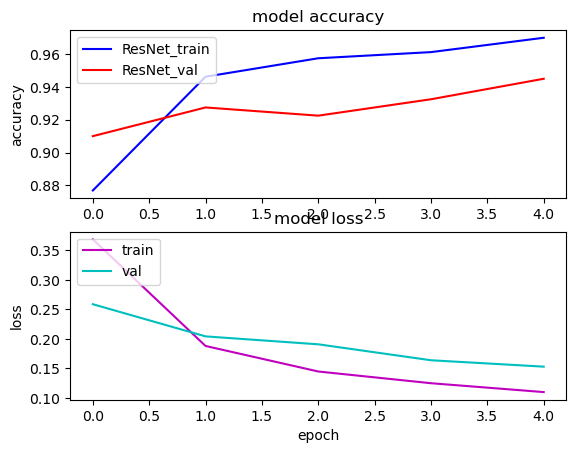

In [22]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.legend(['ResNet_train', 'ResNet_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')